# 循环神经网络

## 序列表示方法

### Embedding层

Embedding 层负责把单词编码为某个词向量$v$， 它接受的是采用数字编码的单词编号$i$，如2表示“I”， 3表示“me”等，系统总单词数量记为$N_{vocab}$， 输出长度为$n$的向量$v$：$$v=f_{\theta}(i|N_{vocab}, n)$$

In [1]:
import tensorflow as tf
from tensorflow.keras import layers

# 生成 10 个单词的数字编码
x = tf.range(10) 
# 打散
x = tf.random.shuffle(x) 
# 创建共 10 个单词，每个单词用长度为 4 的向量表示的层
net = layers.Embedding(10, 4)
# 获取词向量
out = net(x) 
out

<tf.Tensor: id=19, shape=(10, 4), dtype=float32, numpy=
array([[ 0.02974591, -0.03443984, -0.02403122, -0.02153288],
       [-0.03018601,  0.03954509, -0.02528677,  0.03129846],
       [-0.01986039, -0.03339057,  0.03154424, -0.0137913 ],
       [-0.0204801 ,  0.00376071,  0.00240863,  0.02820292],
       [ 0.01496815,  0.04902376, -0.00579251, -0.01775237],
       [ 0.00454669, -0.04509263, -0.00747275,  0.03134331],
       [-0.00305223, -0.01019449, -0.02831918, -0.01832809],
       [-0.01227068,  0.0409546 , -0.01069511, -0.04826144],
       [-0.01523788, -0.02214501, -0.0169457 , -0.00288089],
       [-0.04996878,  0.00628467, -0.04327526, -0.04943682]],
      dtype=float32)>

In [2]:
 net.embeddings

<tf.Variable 'embedding/embeddings:0' shape=(10, 4) dtype=float32, numpy=
array([[-0.00305223, -0.01019449, -0.02831918, -0.01832809],
       [-0.0204801 ,  0.00376071,  0.00240863,  0.02820292],
       [-0.01227068,  0.0409546 , -0.01069511, -0.04826144],
       [ 0.01496815,  0.04902376, -0.00579251, -0.01775237],
       [-0.04996878,  0.00628467, -0.04327526, -0.04943682],
       [-0.01986039, -0.03339057,  0.03154424, -0.0137913 ],
       [ 0.00454669, -0.04509263, -0.00747275,  0.03134331],
       [-0.03018601,  0.03954509, -0.02528677,  0.03129846],
       [-0.01523788, -0.02214501, -0.0169457 , -0.00288089],
       [ 0.02974591, -0.03443984, -0.02403122, -0.02153288]],
      dtype=float32)>

In [3]:
# 查看 net.embeddings 张量的可优化属性为 True，即可以通过梯度下降算法优化
net.embeddings.trainable

True

## 循环神经网络

&emsp;&emsp;网络结构在时间戳上折叠， 网络循环接受序列的每个特征向量$x_t$，并刷新内部状态向量$h_t$，同时形成输出$o_t$。对于这种网络结构，我们把它叫做循环网络结构(Recurrent Neural Network， 简称 RNN)。  
&emsp;&emsp;如果使用张量$W_{xh}$、$W_{hh}$和偏置$b$来参数化$f_\theta$网络，并按照$$h_t=\sigma(W_{xh}x_t+W_{hh}h_{t-1}+b)$$方式更新内存状态，我们把这种网络叫做基本的循环神经网络

## RNN层使用方法

在 TensorFlow 中，可以通过 layers.SimpleRNNCell 来完成$\sigma(W_{xh}x_t+W_{hh}h_{t-1}+b)$计算。

###  SimpleRNNCell

In [4]:
# 创建 RNN Cell，内存向量长度为 3
cell = layers.SimpleRNNCell(3) 
# 输出特征长度 n=4
cell.build(input_shape=(None,4)) 
# 打印 wxh, whh, b 张量
cell.trainable_variables 

[<tf.Variable 'kernel:0' shape=(4, 3) dtype=float32, numpy=
 array([[ 0.4115522 ,  0.22107458, -0.88970715],
        [-0.04243898, -0.02677888,  0.17191768],
        [ 0.6828035 ,  0.90170157, -0.56374496],
        [ 0.8897619 ,  0.6086905 ,  0.06193233]], dtype=float32)>,
 <tf.Variable 'recurrent_kernel:0' shape=(3, 3) dtype=float32, numpy=
 array([[-0.47960746,  0.8641869 , -0.15217681],
        [ 0.56623876,  0.43728444,  0.69868165],
        [ 0.670336  ,  0.2489245 , -0.699061  ]], dtype=float32)>,
 <tf.Variable 'bias:0' shape=(3,) dtype=float32, numpy=array([0., 0., 0.], dtype=float32)>]

In [5]:
# 初始化状态向量，用列表包裹，统一格式
h0 = [tf.zeros([4, 64])]
# 生成输入张量， 4 个 80 单词的句子
x = tf.random.normal([4, 80, 100]) 
# 所有句子的第 1 个单词
xt = x[:,0,:] 
# 构建输入特征 n=100,序列长度 s=80,状态长度=64 的 Cell
cell = layers.SimpleRNNCell(64)
# 前向计算
out, h1 = cell(xt, h0) 
print(out.shape, h1[0].shape)

(4, 64) (4, 64)


In [6]:
print(id(out), id(h1[0]))

492815752 492815752


In [7]:
# h 保存每个时间戳上的状态向量列表
h = h0 
# 在序列长度的维度解开输入，得到 xt:[b,n]
for xt in tf.unstack(x, axis=1):
    # 前向计算,out 和 h 均被覆盖
    out, h = cell(xt, h) 
# 最终输出可以聚合每个时间戳上的输出，也可以只取最后时间戳的输出
out = out

### 多层 SimpleRNNCell 网络

In [8]:
x = tf.random.normal([4,80,100])
# 取第一个时间戳的输入 x0
xt = x[:,0,:] 
# 构建 2 个 Cell,先 cell0,后 cell1，内存状态向量长度都为 64
cell0 = layers.SimpleRNNCell(64)
cell1 = layers.SimpleRNNCell(64)
# cell0 的初始状态向量
h0 = [tf.zeros([4,64])] 
# cell1 的初始状态向量
h1 = [tf.zeros([4,64])] 

在时间轴上面循环计算多次来实现整个网络的前向运算，每个时间戳上的输入 xt 首先通过第一层，得到输出 out0，再通过第二层，得到输出 out1

In [9]:
for xt in tf.unstack(x, axis=1):
    # xt 作为输入，输出为 out0
    out0, h0 = cell0(xt, h0)
    # 上一个 cell 的输出 out0 作为本 cell 的输入
    out1, h1 = cell1(out0, h1)

In [10]:
# 保存上一层的所有时间戳上面的输出
middle_sequences = []
# 计算第一层的所有时间戳上的输出，并保存
for xt in tf.unstack(x, axis=1):
    out0, h0 = cell0(xt, h0)
    middle_sequences.append(out0)
# 计算第二层的所有时间戳上的输出
# 如果不是末层，需要保存所有时间戳上面的输出
for xt in middle_sequences:
    out1, h1 = cell1(xt, h1)

### SimpleRNN 层

单层循环神经网络的前向运算

In [11]:
# 创建状态向量长度为 64 的 SimpleRNN 层
layer = layers.SimpleRNN(64) 
x = tf.random.normal([4, 80, 100])
# 和普通卷积网络一样，一行代码即可获得输出
out = layer(x) 
out.shape

TensorShape([4, 64])

In [12]:
# 创建 RNN 层时，设置返回所有时间戳上的输出
layer = layers.SimpleRNN(64,return_sequences=True)
# 前向计算
out = layer(x) 
# 输出，自动进行了 concat 操作
out.shape

TensorShape([4, 80, 64])

In [13]:
from tensorflow import keras
net = keras.Sequential([ # 构建 2 层 RNN 网络
# 除最末层外，都需要返回所有时间戳的输出，用作下一层的输入
layers.SimpleRNN(64, return_sequences=True),
layers.SimpleRNN(64),
])
out = net(x) # 前向计算
out.shape

TensorShape([4, 64])

## 梯度弥散和梯度爆炸

In [14]:
# 任意创建某矩阵
W = tf.ones([2,2]) 
# 计算矩阵的特征值
eigenvalues = tf.linalg.eigh(W)[0] 
eigenvalues

<tf.Tensor: id=7857, shape=(2,), dtype=float32, numpy=array([0., 2.], dtype=float32)>

In [15]:
val = [W]
for i in range(10): # 矩阵相乘 n 次方
    val.append([val[-1]@W])
# 计算 L2 范数
norm = list(map(lambda x:tf.norm(x).numpy(),val))
norm

[2.0, 4.0, 8.0, 16.0, 32.0, 64.0, 128.0, 256.0, 512.0, 1024.0, 2048.0]

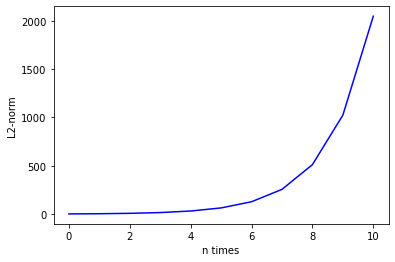

In [16]:
import matplotlib.pyplot as plt

x = range(11)

plt.plot(x, norm, color='blue')
plt.xlabel('n times')
plt.ylabel('L2-norm')
plt.show()

考虑最大特征值小于1时的情况

In [17]:
# 任意创建某矩阵
W = tf.ones([2,2])*0.4 
# 计算特征值
eigenvalues = tf.linalg.eigh(W)[0] 
eigenvalues

<tf.Tensor: id=7948, shape=(2,), dtype=float32, numpy=array([0. , 0.8], dtype=float32)>

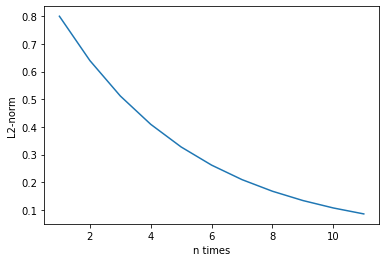

In [18]:
val = [W]
for i in range(10):
    val.append([val[-1]@W])
# 计算 L2 范数
norm = list(map(lambda x:tf.norm(x).numpy(),val))
plt.plot(range(1,12),norm)
plt.xlabel('n times')
plt.ylabel('L2-norm')

plt.show()

## 梯度裁剪

1. 直接对张量的数值进行限幅， 使得张量$W$的所有元素$w_{ij} \in [min, max]$

In [19]:
a=tf.random.uniform([2,2])
# 梯度值裁剪
tf.clip_by_value(a,0.4,0.6) 

<tf.Tensor: id=8044, shape=(2, 2), dtype=float32, numpy=
array([[0.58690715, 0.6       ],
       [0.6       , 0.6       ]], dtype=float32)>

2. 通过限制梯度张量$W$的范数来实现梯度裁剪

In [20]:
a=tf.random.uniform([2,2]) * 5
# 按范数方式裁剪
b = tf.clip_by_norm(a, 5)
# 裁剪前和裁剪后的张量范数
tf.norm(a),tf.norm(b)

(<tf.Tensor: id=8075, shape=(), dtype=float32, numpy=6.7737527>,
 <tf.Tensor: id=8080, shape=(), dtype=float32, numpy=5.0000005>)

3. 全局范数裁剪

In [21]:
# 创建梯度张量 1
w1=tf.random.normal([3,3]) 
# 创建梯度张量 2
w2=tf.random.normal([3,3]) 
# 计算 global norm
global_norm=tf.math.sqrt(tf.norm(w1)**2+tf.norm(w2)**2)
# 根据 global norm 和 max norm=2 裁剪
(ww1,ww2),global_norm=tf.clip_by_global_norm([w1,w2],2)
# 计算裁剪后的张量组的 global norm
global_norm2 = tf.math.sqrt(tf.norm(ww1)**2+tf.norm(ww2)**2)
# 打印裁剪前的全局范数和裁剪后的全局范数
print(global_norm, global_norm2)

tf.Tensor(3.5118904, shape=(), dtype=float32) tf.Tensor(1.9999998, shape=(), dtype=float32)


## LSTM 层使用方法

### LSTMCell

In [22]:
x = tf.random.normal([2,80,100])
# 得到一个时间戳的输入
xt = x[:,0,:] 
cell = layers.LSTMCell(64) # 创建 LSTM Cell
# 初始化状态和输出 List,[h,c]
state = [tf.zeros([2,64]),tf.zeros([2,64])]
out, state = cell(xt, state) # 前向计算
# 查看返回元素的 id
id(out),id(state[0]),id(state[1])

(552212520, 552212520, 552240520)

In [23]:
# 在序列长度维度上解开，循环送入 LSTM Cell 单元
for xt in tf.unstack(x, axis=1):
    # 前向计算
    out, state = cell(xt, state)

### LSTM 层

In [24]:
# 创建一层 LSTM 层，内存向量长度为 64
layer = layers.LSTM(64)
# 序列通过 LSTM 层，默认返回最后一个时间戳的输出 h
out = layer(x)

In [25]:
# 创建 LSTM 层时，设置返回每个时间戳上的输出
layer = layers.LSTM(64, return_sequences=True)
# 前向计算，每个时间戳上的输出自动进行了 concat，拼成一个张量
out = layer(x)

In [26]:
# 和 CNN 网络一样， LSTM 也可以简单地层层堆叠
net = keras.Sequential([
    layers.LSTM(64, return_sequences=True), # 非末层需要返回所有时间戳输出
    layers.LSTM(64)
])
# 一次通过网络模型，即可得到最末层、最后一个时间戳的输出
out = net(x)
out

<tf.Tensor: id=10693, shape=(2, 64), dtype=float32, numpy=
array([[-7.29653612e-02,  1.15865074e-01, -7.15253651e-02,
         7.39371553e-02,  4.68634143e-02,  5.46397939e-02,
         3.66614596e-03, -3.41411717e-02, -9.88797173e-02,
        -7.74470195e-02,  9.54263564e-03,  6.62799105e-02,
         5.46958186e-02, -9.72819999e-02, -5.92009760e-02,
         8.12323615e-02, -2.34329626e-02, -7.07291812e-02,
         2.66989227e-02,  4.51712869e-02,  1.57007724e-01,
        -7.51742488e-03,  1.35744780e-01,  1.02491170e-01,
         4.77755927e-02, -7.14057460e-02, -5.32417037e-02,
         3.11367679e-03,  1.98544171e-02,  1.20310985e-01,
        -3.45447473e-02,  9.80208740e-02, -2.00126737e-01,
         3.35342549e-02,  1.09030381e-02, -8.74172971e-02,
         1.21381782e-01, -1.21675864e-01, -4.28368524e-02,
        -1.63171720e-03,  7.50030763e-03,  6.19905367e-02,
         6.91571087e-02, -1.79095380e-02,  2.11950559e-02,
        -2.99647055e-03,  2.53018010e-02, -1.27889946e-0

## GRU 使用方法

In [27]:
# 初始化状态向量， GRU 只有一个
h = [tf.zeros([2,64])]
# 新建 GRU Cell，向量长度为 64
cell = layers.GRUCell(64) 
# 在时间戳维度上解开，循环通过 cell
for xt in tf.unstack(x, axis=1):
    out, h = cell(xt, h)
# 输出形状
out.shape

TensorShape([2, 64])

通过 layers.GRU 类可以方便创建一层 GRU 网络层，通过 Sequential 容器可以堆叠多层 GRU 层的网络。

In [28]:
net = keras.Sequential([
    layers.GRU(64, return_sequences=True),
    layers.GRU(64)
])
out = net(x)